<a href="https://colab.research.google.com/github/yoonsongg/CS2/blob/main/CS2__Submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# google drive 마운트, 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import packages, libraries
import pandas as pd

In [ ]:
correct_train_url = '/content/drive/MyDrive/AI_Bootcamp/CP1/grade7_correct_train.csv'
itemIRT_train_url = '/content/drive/MyDrive/AI_Bootcamp/CP1/grade7_itemIRT_train.csv'
learnerIRT_train_url = '/content/drive/MyDrive/AI_Bootcamp/CP1/grade7_learnerIRT_train.csv'

correct_valid_url = '/content/drive/MyDrive/AI_Bootcamp/CP1/grade7_correct_valid.csv'
itemIRT_valid_url = '/content/drive/MyDrive/AI_Bootcamp/CP1/grade7_itemIRT_valid.csv'
learnerIRT_valid_url = '/content/drive/MyDrive/AI_Bootcamp/CP1/grade7_learnerIRT_valid.csv'


correct_train = pd.read_csv(correct_train_url)
itemIRT_train = pd.read_csv(itemIRT_train_url)
learnerIRT_train = pd.read_csv(learnerIRT_train_url)


correct_valid = pd.read_csv(correct_valid_url)
itemIRT_valid = pd.read_csv(itemIRT_valid_url)
learnerIRT_valid = pd.read_csv(learnerIRT_valid_url)


In [ ]:
#필요없는 열 삭제
itemIRT_train = itemIRT_train.drop(['Timestamp'], axis = 1)
learnerIRT_train = learnerIRT_train.drop(['Timestamp'], axis = 1)

itemIRT_valid = itemIRT_valid.drop(['Timestamp'], axis = 1)
learnerIRT_valid = learnerIRT_valid.drop(['Timestamp'], axis = 1)

In [ ]:
#train, valid 데이터 셋 만들기 
#train
second_df = pd.merge(left = correct_train, right = itemIRT_train, how = 'left', on = ['testID', 'assessmentItemID'])
train = pd.merge(left = second_df, right = learnerIRT_train, how = 'left', on = ['testID', 'learnerID'])
#valid
se_df = pd.merge(left = correct_valid, right = itemIRT_valid, how = 'left', on = ['testID', 'assessmentItemID'])
valid = pd.merge(left = se_df, right = learnerIRT_valid, how = 'left', on = ['testID', 'learnerID'])

In [ ]:
#여분 만들어두기

train_df = train.copy()
valid_df = valid.copy()

# Feature Engineering


In [ ]:
train.head()

,learnerID,testID,assessmentItemID,answerCode,Timestamp,difficultyLevel,discriminationLevel,guessLevel,KnowledgeTag,learnerProfile,theta,realScore
0,A070001903,A070000094,A070094008,1,2020-08-22 08:19:15,-0.629810,2.806422,0.046112,NaN,F;S01;7,-0.173620,0.635192
1,A070001440,A070000094,A070094006,1,2020-09-14 03:04:07,0.001141,1.060096,0.046260,NaN,F;S01;7,1.293742,0.964566
2,A070001619,A070000094,A070094007,0,2020-09-16 21:30:37,1.139958,13.727655,0.299840,NaN,M;S01;7,0.864086,0.847392
3,A070001032,A070000094,A070094004,0,2020-12-16 04:31:25,-0.869407,3.337444,0.013006,NaN,F;S01;7,-0.791087,0.347025
4,A070001138,A070000094,A070094001,1,2020-08-08 19:34:14,0.785138,8.954192,0.295473,NaN,F;S01;7,1.233376,0.952915


In [ ]:
#각문항별 정답률
def assessment_ratio(df):
    assessmentItemID_groupby = df.groupby('assessmentItemID').agg({'answerCode' : 'mean'})
    df["question_accuracy"] = assessmentItemID_groupby['answerCode'][df['assessmentItemID']].values
    return df


train = assessment_ratio(train)
valid = assessment_ratio(valid)



In [ ]:
train['Timestamp'].dtype

dtype('O')

In [ ]:
#learnerID, test 보는데 걸린 시간
from datetime import datetime

def convert_time(s):
    timestamp = datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
    return timestamp


In [ ]:
train['Timestamp'] = train['Timestamp'].apply(convert_time)
valid['Timestamp'] = valid['Timestamp'].apply(convert_time)

In [ ]:
# def elapsed_time2(df):
#     df_grouped = df.groupby(['learnerID', 'testID'])
#     df_result = pd.DataFrame(df_grouped['Timestamp'].max() - df_grouped['Timestamp'].min())
#     df_result['Timestamp_elapsed'] = df_result['Timestamp'] 
#     df = pd.merge(left = df, right = df_result, how = 'left', on = ['learnerID', 'testID'])
#     return df

# train_df['Timestamp'] = train_df['Timestamp'].apply(convert_time)   
# train_df2 = elapsed_time2(train_df)
# train_df2['Timestamp_elapsed'].describe()

In [ ]:
import numpy as np

def elapsed_time(df):
    df_grouped = df.groupby(['learnerID', 'testID'])
    df_result = pd.DataFrame(df_grouped['Timestamp'].max() - df_grouped['Timestamp'].min())
    df_result['Timestamp_elapsed'] = df_result['Timestamp'] / np.timedelta64(1, 's')
    df = pd.merge(left = df, right = df_result['Timestamp_elapsed'], how = 'left', on = ['learnerID', 'testID'])
    return df
    
train = elapsed_time(train)
valid = elapsed_time(valid)

In [ ]:
#train.loc[df3['learnerID'] == 'A070001903']
train.drop(['answerCode', 'KnowledgeTag','learnerID', 'testID', 'assessmentItemID', 'learnerProfile', 
                                               'Timestamp'], axis = 1)

,difficultyLevel,discriminationLevel,guessLevel,theta,realScore,question_accuracy,Timestamp_elapsed
0,-0.629810,2.806422,0.046112,-0.173620,0.635192,0.736842,1551.0
1,0.001141,1.060096,0.046260,1.293742,0.964566,0.555556,470.0
2,1.139958,13.727655,0.299840,0.864086,0.847392,0.444444,497.0
3,-0.869407,3.337444,0.013006,-0.791087,0.347025,0.830409,140.0
4,0.785138,8.954192,0.295473,1.233376,0.952915,0.467836,978.0
...,...,...,...,...,...,...,...
210545,-0.912698,2.738417,0.000716,-0.375466,0.591677,0.757962,92.0
210546,0.059957,1.953217,0.058159,-0.791601,0.429591,0.515924,664.0
210547,-0.711114,2.566996,0.128130,0.601050,0.852480,0.751592,178.0
210548,-1.220074,1.694204,0.001264,-0.150753,0.672055,0.796178,347.0


In [ ]:
#시험보는데 걸린시간 아웃라이어 제거

def outlier_IQR(df):
    q1 = df['Timestamp_elapsed'].quantile(.25)
    q3 = df['Timestamp_elapsed'].quantile(.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    condition = df[(df['Timestamp_elapsed'] > upper) | (df['Timestamp_elapsed'] < lower)].index
    df = df.drop(condition).reset_index()
    return df

train = outlier_IQR(train)
valid = outlier_IQR(valid)
print(train.shape)

(190646, 15)


In [ ]:
train['Timestamp_elapsed'].describe()
print(datetime.timedelta(seconds = 1483))

0:24:43


In [ ]:
train.head()

,index,learnerID,testID,assessmentItemID,answerCode,Timestamp,difficultyLevel,discriminationLevel,guessLevel,KnowledgeTag,learnerProfile,theta,realScore,question_accuracy,Timestamp_elapsed
0,1,A070001440,A070000094,A070094006,1,2020-09-14 03:04:07,0.001141,1.060096,0.046260,NaN,F;S01;7,1.293742,0.964566,0.555556,470.0
1,2,A070001619,A070000094,A070094007,0,2020-09-16 21:30:37,1.139958,13.727655,0.299840,NaN,M;S01;7,0.864086,0.847392,0.444444,497.0
2,3,A070001032,A070000094,A070094004,0,2020-12-16 04:31:25,-0.869407,3.337444,0.013006,NaN,F;S01;7,-0.791087,0.347025,0.830409,140.0
3,4,A070001138,A070000094,A070094001,1,2020-08-08 19:34:14,0.785138,8.954192,0.295473,NaN,F;S01;7,1.233376,0.952915,0.467836,978.0
4,5,A070001897,A070000094,A070094001,0,2020-11-19 01:41:55,0.785138,8.954192,0.295473,NaN,M;S01;7,-0.571749,0.448073,0.467836,744.0


In [ ]:
train2 = train.copy()
train3 = train.copy()

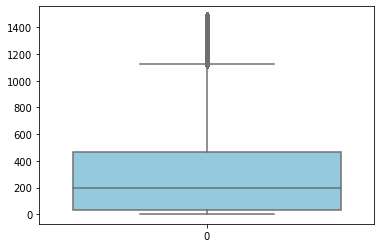

In [ ]:
import seaborn as sns
sns.boxplot(data = train['Timestamp_elapsed'], color = 'skyblue')
#sns.boxplot(data = train['theta'])

In [ ]:
train['Timestamp_elapsed'].describe()

count    190646.000000
mean        312.275783
std         336.512741
min           3.000000
25%          34.000000
50%         197.000000
75%         470.000000
max        1483.000000
Name: Timestamp_elapsed, dtype: float64

In [ ]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import torch

In [ ]:
train_tensor = torch.from_numpy(train_df.drop(['answerCode', 'KnowledgeTag',
                                               'learnerID', 'testID', 'assessmentItemID', 'learnerProfile', 
                                               'Timestamp'], axis = 1).values).float()

print(type(train_tensor))
print(train_tensor[0])
print(train_tensor[1])

<class 'torch.Tensor'>
tensor([-0.6298,  2.8064,  0.0461, -0.1736,  0.6352])
tensor([1.1412e-03, 1.0601e+00, 4.6260e-02, 1.2937e+00, 9.6457e-01])


#Dataset, dataloader
### CustomDataset에서 dataframe -> array -> tensor 로 바꿔주는 과정 필요

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.x = df.drop(['answerCode', 'KnowledgeTag','learnerID','index', 
                          'testID', 'assessmentItemID', 'learnerProfile', 'Timestamp'], axis = 1).values
        self.y = df['answerCode'].values
        #.float()해서 float64 -> float 로 변형
        #아래 두 줄을 __getitem__ method 아래 두었으나 tensor로 변형되지 않아서 __init__ method로 넣음. 왜??? 
        self.x = torch.from_numpy(self.x).float()
        self.y = torch.from_numpy(self.y).float()

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x, self.y

    



In [ ]:
batch_size = 256
input_size = 7
hidden_size = 8
num_layers = 2
num_classes = 2
lr = 0.001

In [ ]:
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(valid)

#dataset = torch.utils.data.TensorDataset(dataset.x, dataset.y)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# for b , sample in enumerate(train_loader):
#     print(sample[1])

In [ ]:
print(type(train_dataset.x[-1:]))

print(train_dataset.x[-1:])
print(type(train_dataset.x))
print(type(train_dataset.y))
#print(dataset.y)

<class 'torch.Tensor'>
tensor([[5.9957e-02, 1.9532e+00, 5.8159e-02, 5.8830e-01, 8.5031e-01, 5.1592e-01,
         1.3900e+02]])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# def generate_batches(dataset, batch_size, shuffle = True, drop_last = True, device = "gpu"):
#     dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, drop_last = drop_last)
#     for data_dict in dataloader:
#         out_data_dict = {}
#         for name, tensor in data_dict.items():
#             out_data_dict[name] = data_dict[name].to(device)
#         yield out_data_dict

#model

In [ ]:
# USE_CUDA = torch.cuda.is_available()
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__() # 상속한 nn.Module에서 RNN에 해당하는 init 실행
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x): 
        # input x : (BATCH, LENGTH, INPUT_SIZE) 입니다 (다양한 length를 다룰 수 있습니다.).
        # 최초의 hidden state와 cell state를 초기화시켜주어야 합니다.
        # 배치 사이즈는 가변적이므로 클래스 내에선 표현하지 않습니다.
        # 만약 Bi-directional LSTM이라면 아래의 hidden and cell states의 첫번째 차원은 2*self.num_layers 입니다. 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)# (BATCH SIZE, SEQ_LENGTH, HIDDEN_SIZE)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # hidden state와 동일

        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0)) # output : (BATCH_SIZE, SEQ_LENGTH, HIDDEN_SIZE) tensors. (hn, cn)은 필요 없으므로 받지 않고 _로 처리합니다. 

        # 마지막 time step(sequence length)의 hidden state를 사용해 Class들의 logit을 반환합니다(hidden_size -> num_classes). 
        out = self.fc(out[:, -1, :])
        return out



In [ ]:
# #DKT (https://github.com/hcnoh/knowledge-tracing-collection-pytorch/blob/main/models/dkt.py)
# import os

# import numpy as np
# import torch

# from torch.nn import Module, Embedding, LSTM, Linear, Dropout
# from torch.nn.functional import one_hot, binary_cross_entropy
# from sklearn import metrics


# class DKT(Module):
#     '''
#         Args:
#             num_q: the total number of the questions(KCs) in the given dataset
#             emb_size: the dimension of the embedding vectors in this model
#             hidden_size: the dimension of the hidden vectors in this model
#     '''
#     def __init__(self, num_q, emb_size, hidden_size):
#         super().__init__()
#         self.num_q = num_q
#         self.emb_size = emb_size
#         self.hidden_size = hidden_size

#         self.interaction_emb = Embedding(self.num_q * 2, self.emb_size)
#         self.lstm_layer = LSTM(
#             self.emb_size, self.hidden_size, batch_first=True
#         )
#         self.out_layer = Linear(self.hidden_size, self.num_q)
#         self.dropout_layer = Dropout()

#     def forward(self, q, r):
#         '''
#             Args:
#                 q: the question(KC) sequence with the size of [batch_size, n]
#                 r: the response sequence with the size of [batch_size, n]
#             Returns:
#                 y: the knowledge level about the all questions(KCs)
#         '''
#         x = q + self.num_q * r

#         h, _ = self.lstm_layer(self.interaction_emb(x))
#         y = self.out_layer(h)
#         y = self.dropout_layer(y)
#         y = torch.sigmoid(y)

#         return y

#     def train_model(
#         self, train_loader, test_loader, num_epochs, opt, ckpt_path
#     ):
#         '''
#             Args:
#                 train_loader: the PyTorch DataLoader instance for training
#                 test_loader: the PyTorch DataLoader instance for test
#                 num_epochs: the number of epochs
#                 opt: the optimization to train this model
#                 ckpt_path: the path to save this model's parameters
#         '''
#         aucs = []
#         loss_means = []

#         max_auc = 0

#         for i in range(1, num_epochs + 1):
#             loss_mean = []

#             for data in train_loader:
#                 q, r, qshft, rshft, m = data

#                 self.train()

#                 y = self(q.long(), r.long())
#                 y = (y * one_hot(qshft.long(), self.num_q)).sum(-1)

#                 y = torch.masked_select(y, m)
#                 t = torch.masked_select(rshft, m)

#                 opt.zero_grad()
#                 loss = binary_cross_entropy(y, t)
#                 loss.backward()
#                 opt.step()

#                 loss_mean.append(loss.detach().cpu().numpy())

#             with torch.no_grad():
#                 for data in test_loader:
#                     q, r, qshft, rshft, m = data

#                     self.eval()

#                     y = self(q.long(), r.long())
#                     y = (y * one_hot(qshft.long(), self.num_q)).sum(-1)

#                     y = torch.masked_select(y, m).detach().cpu()
#                     t = torch.masked_select(rshft, m).detach().cpu()

#                     auc = metrics.roc_auc_score(
#                         y_true=t.numpy(), y_score=y.numpy()
#                     )

#                     loss_mean = np.mean(loss_mean)

#                     print(
#                         "Epoch: {},   AUC: {},   Loss Mean: {}"
#                         .format(i, auc, loss_mean)
#                     )

#                     if auc > max_auc:
#                         torch.save(
#                             self.state_dict(),
#                             os.path.join(
#                                 ckpt_path, "model.ckpt"
#                             )
#                         )
#                         max_auc = auc

#                     aucs.append(auc)
#                     loss_means.append(loss_mean)

#         return aucs, loss_means

In [ ]:
#model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
model = RNN(input_size, hidden_size, num_layers, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()


In [ ]:
# nb_epochs = 10
# for epoch in range(nb_epochs + 1):
#     for batch_idx, samples in enumerate(train_loader):
#         # print(batch_idx)
#         # print(samples)
#         x_train, y_train = samples
        
#         prediction = model(x_train)

#         loss = criterion(prediction, y_train)


#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


#         print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
#         epoch, nb_epochs, batch_idx+1, len(dataloader), cost.item()
#         ))

#train

In [ ]:
train_iter = train_loader
val_iter = test_loader

In [ ]:
def train(model, optimizer, train_loader):
    model.train()
    for b, batch in enumerate(train_loader):
        x, y = batch[0], batch[1]
        #y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [ ]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

NameError: ignored

In [ ]:
import torch 
from torch.optim import Adam

#model = nn.LSTM(input_size = 7, hidden_size = 2, 2)
model = torch.nn.LSTM(input_size = 7, hidden_size = 2, num_layers = 2, batch_first = True)
#model = torch.nn.GRU(7, 1, 1)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
#batch_generator = generate_batches(train, batch_size = 20)

In [ ]:
# nb_epochs = 20
# for epoch in range(nb_epochs + 1):
#     for batch_idx, samples in enumerate(dataloader):
#         print(batch_idx)
#         print(samples)
#         x_train, y_train = samples
#         prediction = model(x_train)

#         prediction = torch.nn.BCEWithLogitsLoss()
#         #loss = criterion(prediction, y_train)

#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()


#         print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
#         epoch, nb_epochs, batch_idx+1, len(dataloader), cost.item()
#         ))


#평가

In [ ]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        #y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy